In [1]:
import geopandas as gpd
import numpy as np
from shapely.geometry import Point, LineString
import pandas as pd
import networkx as nx
import sqlite3
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap


/opt/homebrew/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
with sqlite3.connect('../../Dataset/submarine_cable.sqlite') as con:
    c = con.cursor()
    cable_coor = pd.read_sql("select  geometry, lp.cable_id, lp.cable_name, cmlcc.merge_length as cable_length, cmlcc.merge_capacity as cable_capacity, cmlcc.merge_cost as cable_cost from landing_points lp left join cable_coor cc on lp.cable_id = cc.id left join cable_merge_length_capacity_cost cmlcc on lp.cable_id = cmlcc.cable_id group by geometry",con=con)
# cable_shap = gpd.GeoDataFrame(cable_coor, crs=4326)

In [3]:
cable_coor[cable_coor['cable_length'].isna() == True]

,geometry,cable_id,cable_name,cable_length,cable_capacity,cable_cost


In [4]:
cleaned_cable_coor = cable_coor["geometry"].str.replace("MULTILINESTRING \(\(", "").str.replace("\)", "").str.replace("'","")
# coor_list = cleaned_cable_coor.iloc[0].split(', (')
cleaned_cable_coor.iloc[2].split(', (')

index_cable_id = list(cable_coor.columns).index('cable_id')
index_cable_length = list(cable_coor.columns).index('cable_length')
index_cable_capacity = list(cable_coor.columns).index('cable_capacity')
index_cable_cost = list(cable_coor.columns).index('cable_cost')


data = pd.DataFrame()

for row in range(cleaned_cable_coor.shape[0]):
    coor_list = cleaned_cable_coor.iloc[row].split(', (')
    cable_id = cable_coor.iloc[row,index_cable_id]
    cable_length = cable_coor.iloc[row,index_cable_length]
    cable_capacity = cable_coor.iloc[row,index_cable_capacity]
    cable_cost = cable_coor.iloc[row,index_cable_cost]

    for x in coor_list:
        seg = pd.DataFrame()
        abc = x.split(', ')
        # print(abc)
        for y in abc:
            a = {'lon1': y.split(' ')[0], 'lat1': y.split(' ')[1], 'cable_id': cable_id, 'cable_length': cable_length, 'cable_capacity': cable_capacity,'cable_cost': cable_cost}
            seg = seg.append(a,ignore_index=True)
        seg["lon1"] = seg["lon1"].astype("float64")
        seg["lat1"] = seg["lat1"].astype("float64")
        seg['lon2'] = seg['lon1'].shift()
        seg['lat2'] = seg['lat1'].shift()
        data = data.append(seg,ignore_index=True)
data

/var/folders/93/98m4gg790h36hw_xcd31b1d40000gn/T/ipykernel_89897/2595705227.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  cleaned_cable_coor = cable_coor["geometry"].str.replace("MULTILINESTRING \(\(", "").str.replace("\)", "").str.replace("'","")


,lon1,lat1,cable_id,cable_length,cable_capacity,cable_cost,lon2,lat2
0,-0.134426,50.828479,crosschannel-fibre,149.0,2400.000000,3.875,NaN,NaN
1,0.000074,50.597677,crosschannel-fibre,149.0,2400.000000,3.875,-0.134426,50.828479
2,0.450074,50.022920,crosschannel-fibre,149.0,2400.000000,3.875,0.000074,50.597677
3,0.797774,49.877307,crosschannel-fibre,149.0,2400.000000,3.875,0.450074,50.022920
4,-0.204316,5.558286,glo-1,9800.0,2.500000,260.000,NaN,NaN
...,...,...,...,...,...,...,...,...
11075,101.250003,2.425987,damai-cable-system,575.0,44.384991,14.375,100.575003,2.705081
11076,101.758252,2.143087,damai-cable-system,575.0,44.384991,14.375,101.250003,2.425987
11077,101.870752,1.976445,damai-cable-system,575.0,44.384991,14.375,101.758252,2.143087
11078,101.728127,1.805588,damai-cable-system,575.0,44.384991,14.375,101.870752,1.976445


In [5]:
# data['lon2'] = data['lon1'].shift()
# data['lat2'] = data['lat1'].shift()
# data["lon1"] = data["lon1"].astype("float64")
# data["lat1"] = data["lat1"].astype("float64")

In [6]:
# cable_coor.iloc[0,1]
# cable_coor.iloc[2,1]

In [7]:
# data.dropna()
gdf = gpd.GeoDataFrame(data)
    # data,geometry=gpd.points_from_xy(data.lon1, data.lat1), crs=4326)
gdf['fr_point'] = gpd.points_from_xy(x=gdf['lon1'],y=gdf['lat1'])
gdf['to_point'] = gpd.points_from_xy(x=gdf['lon2'],y=gdf['lat2'])

gdf['fr_id'] = round((round(gdf['lon1'],5) + round(gdf['lat1'],5))*100000,0)
gdf['to_id'] = round((round(gdf['lon2'],5) + round(gdf['lat2'],5))*100000,0)
gdf['distance_from_previous'] = gdf['fr_point'].distance(gdf['to_point'])
gdf['total_distance'] = gdf.groupby('cable_id')['distance_from_previous'].transform('sum')
gdf['length_from_previous'] = gdf['cable_length'] / gdf['total_distance'] * gdf['distance_from_previous']

# gdf['distance_from_previous'] = gdf.distance(gdf.shift(1))

In [8]:
gdf[gdf['cable_length'].isna()==True]

,lon1,lat1,cable_id,cable_length,cable_capacity,cable_cost,lon2,lat2,fr_point,to_point,fr_id,to_id,distance_from_previous,total_distance,length_from_previous


In [9]:
gdf = gdf[gdf['to_id'].isna() == False].iloc[1::,]
gdf['line'] = gdf.apply(lambda row: LineString([row['fr_point'], row['to_point']]), axis=1) #Create a linestring column


In [10]:
gdf.to_csv("/Users/dijiongyuequ/Downloads/cable_distance.csv")

<AxesSubplot:>

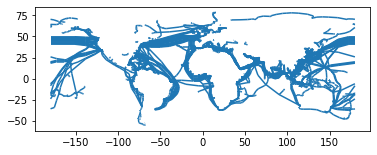

In [11]:
gdf = gpd.GeoDataFrame(gdf, geometry=gdf['line'])
gdf.plot()

In [12]:
gdf = gdf.reset_index( )


In [13]:
gdf.sample(5)

,index,lon1,lat1,cable_id,cable_length,cable_capacity,cable_cost,lon2,lat2,fr_point,to_point,fr_id,to_id,distance_from_previous,total_distance,length_from_previous,line,geometry
1475,1686,-7.199921,51.306376,exa-express,4600.0,53.000000,120.000,-7.649920,51.586834,POINT (-7.19992 51.30638),POINT (-7.64992 51.58683),4410646.0,4393691.0,0.530242,62.776314,38.854036,LINESTRING (-7.199920663568747 51.306375677382...,"LINESTRING (-7.19992 51.30638, -7.64992 51.58683)"
8504,9677,57.262534,25.348717,falcon,10300.0,2.560000,900.000,56.812534,26.159308,POINT (57.26253 25.34872),POINT (56.81253 26.15931),8261125.0,8297184.0,0.927123,109.258013,87.401967,LINESTRING (57.26253367062375 25.3487174221168...,"LINESTRING (57.26253 25.34872, 56.81253 26.15931)"
8695,9897,50.400039,26.964305,gulf-bridge-international-cable-system-gbicsmi...,5270.0,51.200000,445.000,50.231289,26.461844,POINT (50.40004 26.96430),POINT (50.23129 26.46184),7736434.0,7669313.0,0.530041,46.834215,59.642642,LINESTRING (50.400038532079606 26.964304734562...,"LINESTRING (50.40004 26.96430, 50.23129 26.46184)"
6361,7250,14.458764,35.934056,malta-italy-interconnector,95.0,14.025692,2.375,14.512564,36.149867,POINT (14.45876 35.93406),POINT (14.51256 36.14987),5039282.0,5066243.0,0.222416,0.885856,23.852122,LINESTRING (14.458763993215797 35.934055517066...,"LINESTRING (14.45876 35.93406, 14.51256 36.14987)"
2730,3119,-83.249867,13.492128,arcos,8600.0,8.400000,250.000,-83.249867,12.615396,POINT (-83.24987 13.49213),POINT (-83.24987 12.61540),-6975774.0,-7063447.0,0.876733,72.090261,104.589723,LINESTRING (-83.24986678907352 13.492128176464...,"LINESTRING (-83.24987 13.49213, -83.24987 12.6..."


In [14]:
G = nx.from_pandas_edgelist(gdf, 'fr_id', 'to_id', edge_attr=['index', 'length_from_previous'], create_using=nx.Graph)


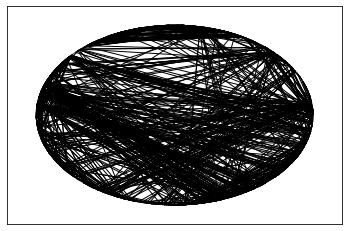

In [15]:
nx.draw_networkx_edges(G, pos=nx.circular_layout(G))


In [16]:
nx.degree_centrality(G)

{5047299.0: 0.00021422450728363326,
 5059775.0: 0.00010711225364181663,
 5067508.0: 0.00010711225364181663,
 282991.0: 0.00021422450728363326,
 535397.0: 0.0006426735218508998,
 170619.0: 0.0003213367609254499,
 4430808.0: 0.00021422450728363326,
 4628380.0: 0.000856898029134533,
 4208301.0: 0.00021422450728363326,
 3880431.0: 0.00021422450728363326,
 2965160.0: 0.00021422450728363326,
 2529840.0: 0.00021422450728363326,
 2228574.0: 0.00021422450728363326,
 2036479.0: 0.00021422450728363326,
 1752613.0: 0.00021422450728363326,
 1466113.0: 0.00021422450728363326,
 1233938.0: 0.00021422450728363326,
 533474.0: 0.00021422450728363326,
 105271.0: 0.00021422450728363326,
 -409876.0: 0.00021422450728363326,
 -716426.0: 0.00021422450728363326,
 -891421.0: 0.00021422450728363326,
 -888501.0: 0.00021422450728363326,
 -888169.0: 0.00021422450728363326,
 -168169.0: 0.00021422450728363326,
 484188.0: 0.00021422450728363326,
 562920.0: 0.00021422450728363326,
 686498.0: 0.00021422450728363326,
 986

In [17]:
# nx.current_flow_closeness_centrality(G,weight='length_from_previous')

In [18]:
path = nx.shortest_path(G,6181995, 4629267, weight = 'length_from_previous')

# def getPath(path, road):
#     pathroad = pd.DataFrame()
#     for i in range(5):
#         # len(path.keys())-1
#         node1 = path[list (path.keys())[i]]
#         print(node1)
#         node2 = path[list (path.keys())[i+1]]
#         print(node2)
#         r = road[(road['fr_id'] == node1) & (road['to_id'] == node2)]
#         pathroad = pathroad.append(r)
#     return pathroad

def getPath(path, road):
    pathroad = pd.DataFrame()
    for i in range(len(path)-1):
        # len(path.keys())-1
        node1 = path[i]
        node2 = path[i+1]
        # fr_id and to_id might be in opposite order
        r = road[ ((road['fr_id'] == node1) & (road['to_id'] == node2)) | (road['fr_id'] == node2) & (road['to_id'] == node1) ]
        pathroad = pathroad.append(r)
    return pathroad

In [19]:
for x in (nx.connected_components(G)):
    print(len(x))

3
6724
287
9
4
466
7
7
220
10
10
4
3
51
7
4
32
9
88
6
33
8
23
3
42
17
28
9
23
9
3
3
5
9
21
3
3
3
3
3
3
3
3
3
3
3
3
4
3
3
9
5
4
4
21
4
14
18
4
6
4
7
16
13
4
9
4
16
6
3
9
4
8
6
38
3
3
3
10
4
38
10
3
3
14
6
4
5
4
5
8
4
4
3
3
130
5
3
15
4
4
4
4
52
3
3
5
4
11
4
5
4
5
3
10
4
3
6
3
6
4
3
3
7
7
3
10
10
4
44
4
5
7
35
6
6
3
4
4
4
7
5
3
4
4
4
18
7
9
8
4
5
4
3
4
3
6
7
9
7
7
6
12
4
5
3
13
12
3
14
10
5
18
4
4
3
5
5
4


## Centrality

In [20]:
# getPath(max(nx.connected_components(G), key=len),gdf).plot()
raw_centrality = gdf[gdf['fr_id'].isin(max(nx.connected_components(G), key=len))]


In [21]:
raw_centrality['centrality'] = raw_centrality['fr_id'].map(nx.degree_centrality(G))
raw_centrality.to_csv('/Users/dijiongyuequ/Downloads/cable_centrality_length.csv')


/opt/homebrew/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [22]:
with sqlite3.connect('../../Dataset/submarine_cable.sqlite') as con:
    c = con.cursor()
    centrality = pd.read_sql("select landingPoint_country,landingPoint_id,landingPoint_longitude,landingPoint_latitude, sum(centrality)as country_centrality from cable_centrality_length join landing_points lp on round(lon1,3) = round(landingPoint_longitude,3) and round(lat1,3) = round(landingPoint_latitude,3) group by  landingPoint_country order by country_centrality desc",con=con)
centrality.head(10)

,landingPoint_country,landingPoint_id,landingPoint_longitude,landingPoint_latitude,country_centrality
0,India,mumbai-india,72.875866,19.076080,0.463484
1,Singapore,tuas-singapore,103.646210,1.338646,0.432545
2,Japan,okinawa-japan,127.680794,26.212370,0.369627
3,Saudi Arabia,jeddah-saudi-arabia,39.182863,21.481547,0.228916
4,Brazil,fortaleza-brazil,-38.542965,-3.718834,0.216421
5,United States,north-miami-beach-fl-united-states,-80.162381,25.932943,0.194556
6,France,penmarch-france,-4.338692,47.811315,0.190540
7,Indonesia,anyer-indonesia,105.883913,-6.073693,0.162576
8,United Arab Emirates,abu-dhabi-united-arab-emirates,54.418960,24.443960,0.156180
9,Pakistan,karachi-pakistan,67.028539,24.889677,0.089395


In [23]:
world_map = folium.Map(location=[20,0], tiles="OpenStreetMap", zoom_start=2)
country_centrality=centrality["country_centrality"]*100
lon=centrality["landingPoint_longitude"]
lat=centrality["landingPoint_latitude"]
num=centrality.shape[0]
for i in range(num):
    folium.CircleMarker(radius=float(country_centrality[i]),location=[lat[i],lon[i]],color="crimson",fill=True,fill_color="crimson",fill_opacity=0.7).add_to(world_map)
world_map

In [24]:
raw_centrality['inverse_capacity'] = 1/raw_centrality['cable_capacity']
G2 = nx.from_pandas_edgelist(raw_centrality, 'fr_id', 'to_id', edge_attr=['index', 'length_from_previous','cable_capacity', 'inverse_capacity','cable_cost'], create_using=nx.Graph)

nx.algorithms.efficiency(G2,6158154, 4629267)



/opt/homebrew/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


0.029411764705882353

/opt/homebrew/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:>

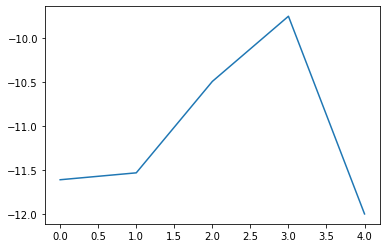

In [25]:
dict_rickClub = nx.algorithms.rich_club_coefficient(G2,normalized=False)
df_rickClub = pd.DataFrame(dict_rickClub.values(),columns=['rich_club_coefficient'])
df_rickClub['log(rich_club)'] = np.log2(df_rickClub['rich_club_coefficient'])
df_rickClub['log(rich_club)'].plot()

# Betweenness centrality

In [26]:
worldMap = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


In [27]:
# raw_centrality.
dict_betweennessCentrality_length = nx.algorithms.betweenness_centrality(G2,weight='length_from_previous')
df_betweennessCentrality_length = pd.DataFrame({'betCentralityId': dict_betweennessCentrality_length.keys(), 'betCentralityValue': dict_betweennessCentrality_length.values()}).sort_values(by=['betCentralityValue'])


(-50.0, 75.0)

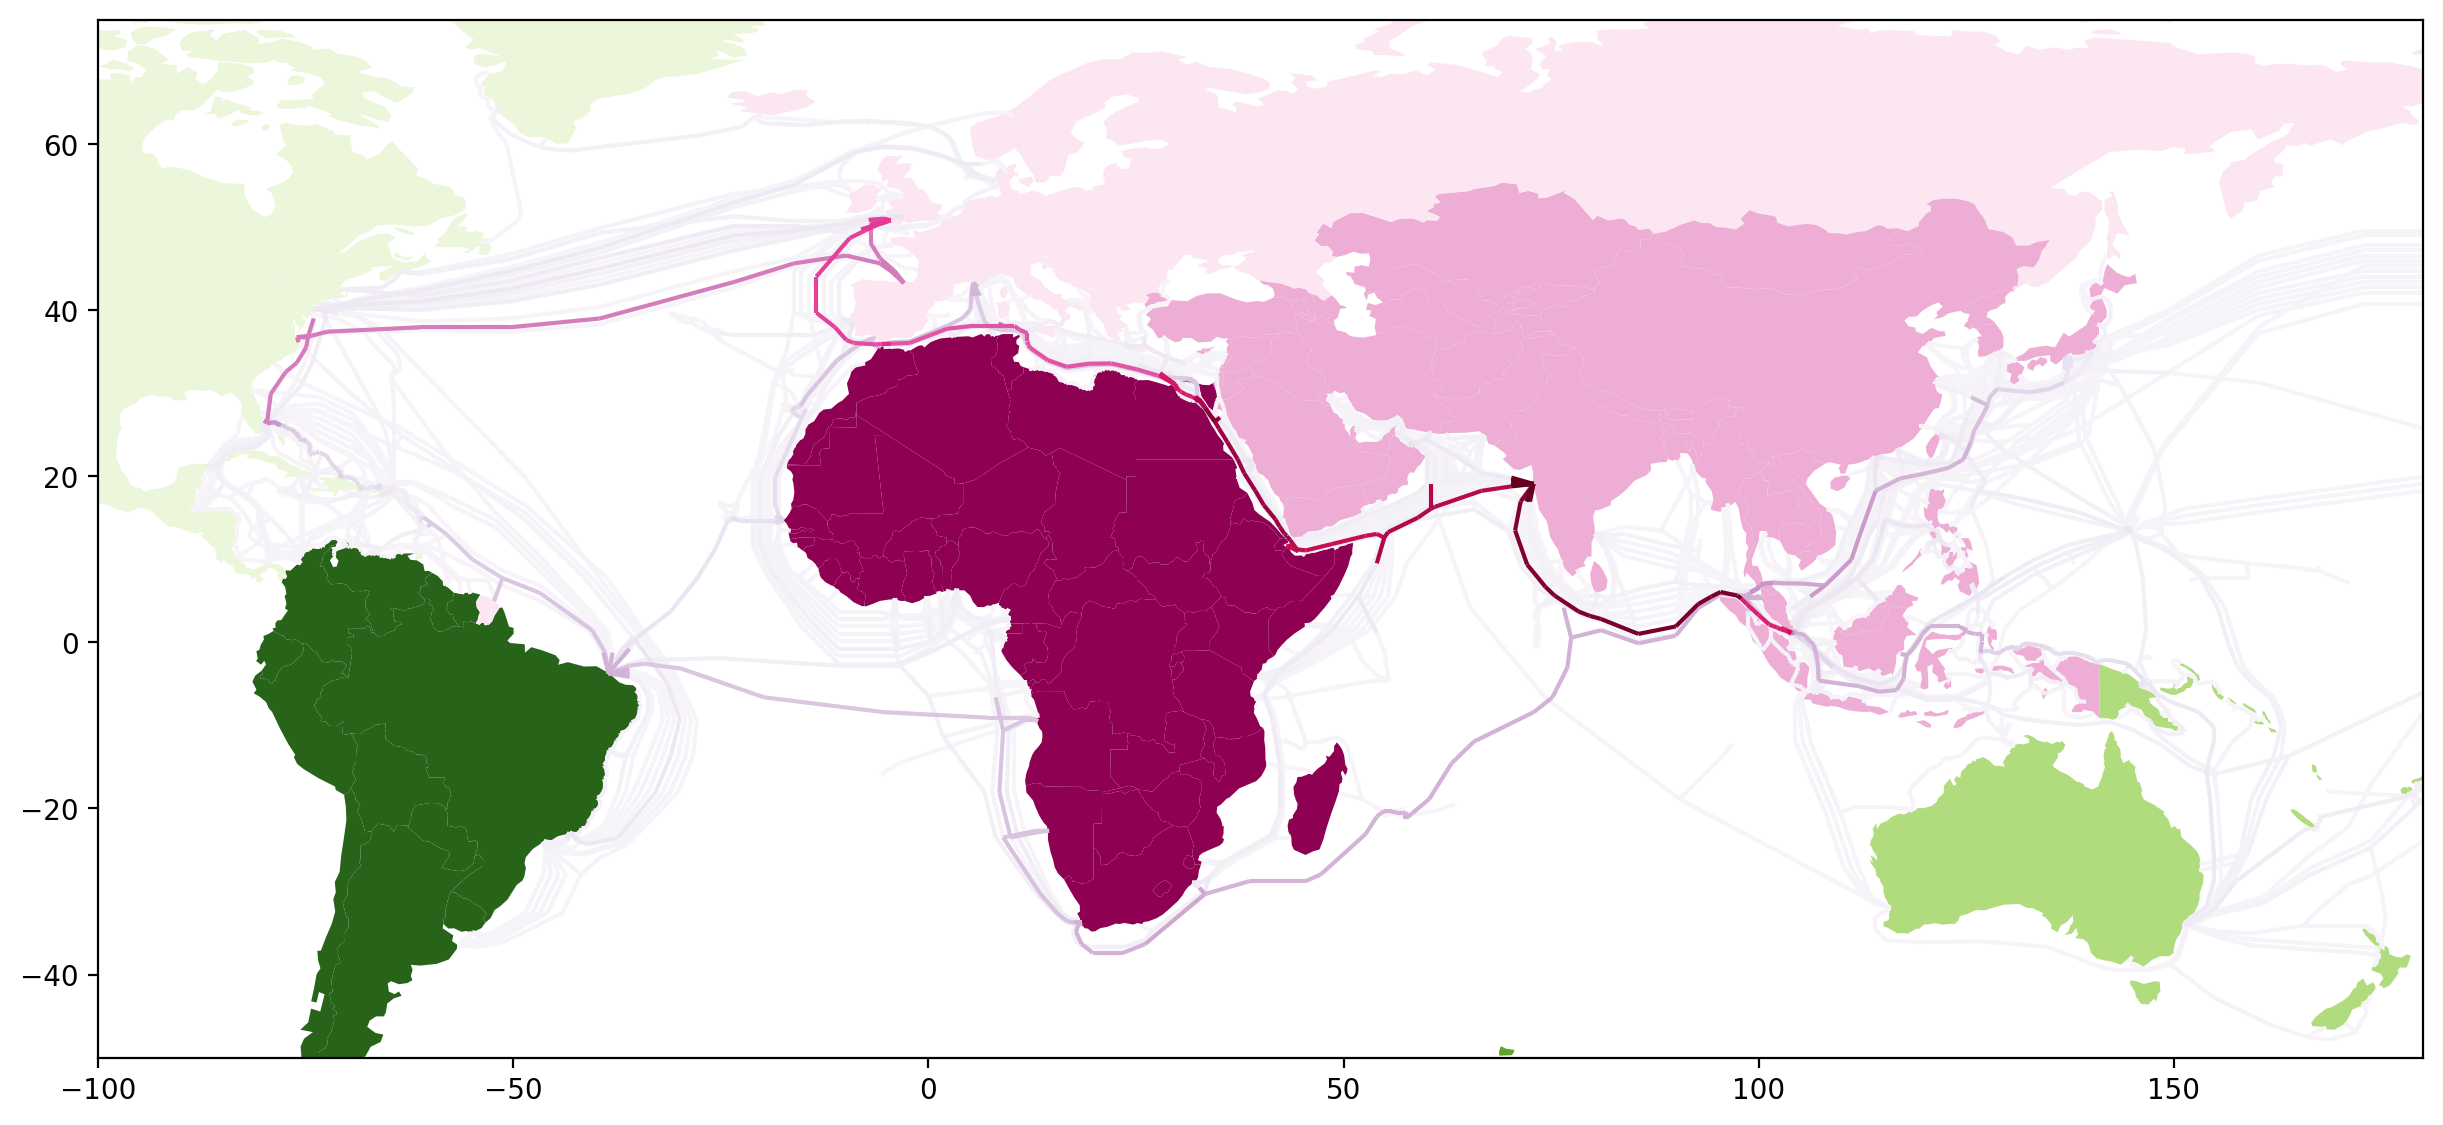

In [28]:
fig     = plt.figure(figsize=(15,10),dpi = 200)
ax      = plt.subplot(111)
worldMap.plot(column = 'continent', ax=ax, cmap = 'PiYG')
raw_centrality.merge(right=df_betweennessCentrality_length, how='inner',left_on='fr_id', right_on='betCentralityId').sort_values(by=['betCentralityValue']).plot(column = 'betCentralityValue',ax=ax,cmap='PuRd')
plt.xlim([-100,180])
plt.ylim([-50,75])

In [29]:
dict_betweennessCentrality_capacity = nx.algorithms.betweenness_centrality(G2,weight='cable_capacity')
df_betweennessCentrality_capacity = pd.DataFrame({'betCentralityId': dict_betweennessCentrality_capacity.keys(), 'betCentralityValue': dict_betweennessCentrality_capacity.values()}).sort_values(by=['betCentralityValue'])


(-50.0, 75.0)

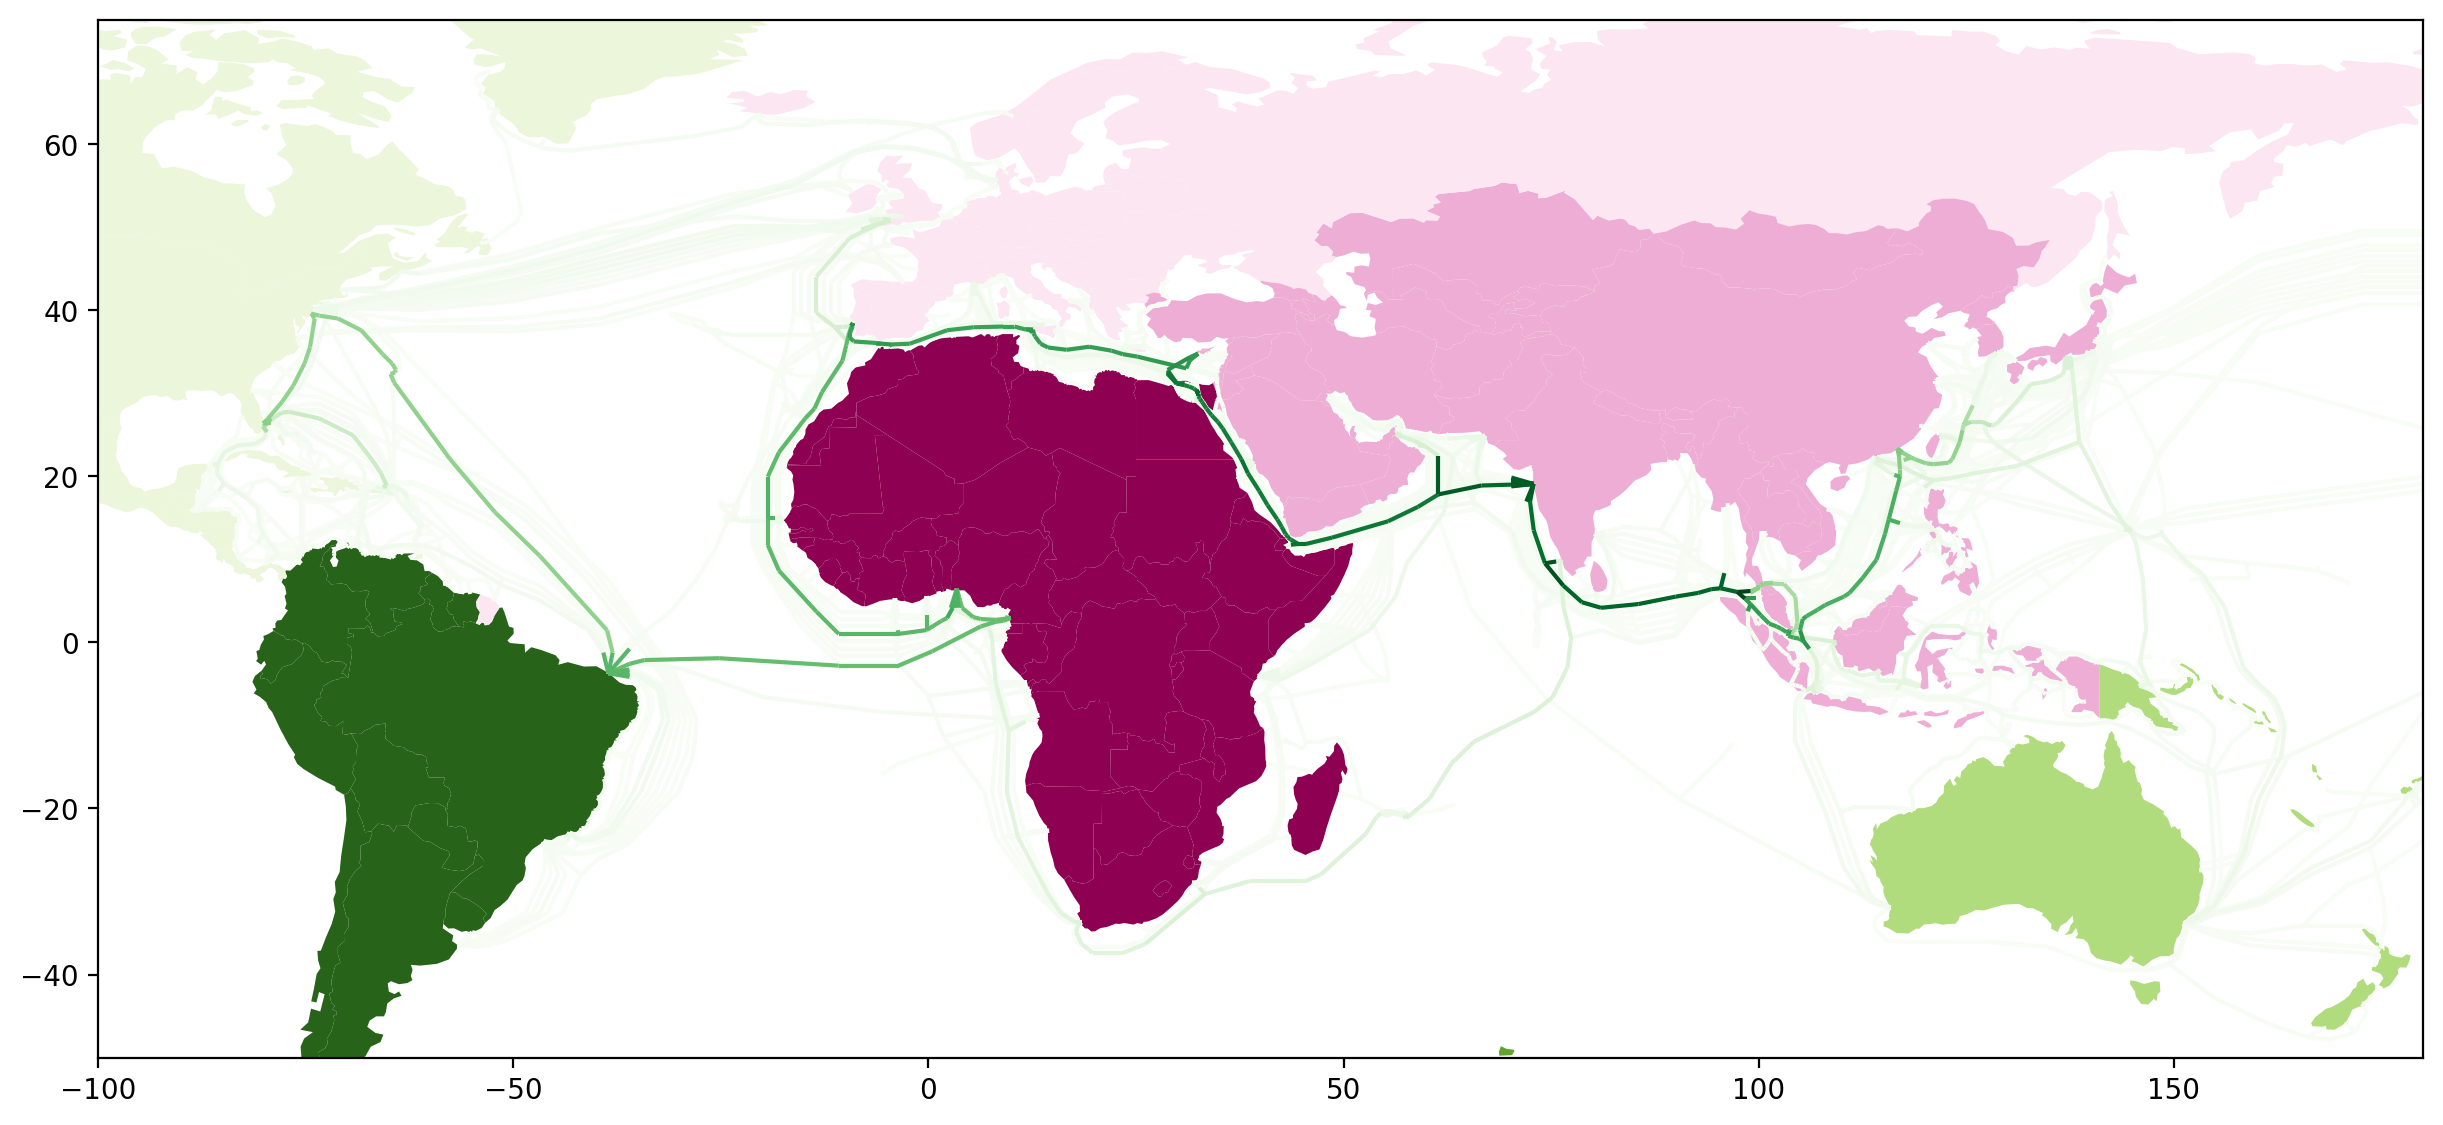

In [30]:
fig     = plt.figure(figsize=(15,10),dpi = 200)
ax      = plt.subplot(111)
worldMap.plot(column = 'continent', ax=ax, cmap = 'PiYG')
raw_centrality.merge(right=df_betweennessCentrality_capacity, how='inner',left_on='fr_id', right_on='betCentralityId').sort_values(by=['betCentralityValue']).plot(column = 'betCentralityValue',ax=ax,cmap='Greens')
plt.xlim([-100,180])
plt.ylim([-50,75])



In [31]:
# raw_centrality.
dict_betweennessCentrality_cost = nx.algorithms.betweenness_centrality(G2,weight='cable_cost')
df_betweennessCentrality_cost = pd.DataFrame({'betCentralityId': dict_betweennessCentrality_cost.keys(), 'betCentralityValue': dict_betweennessCentrality_cost.values()}).sort_values(by=['betCentralityValue'])


(-50.0, 75.0)

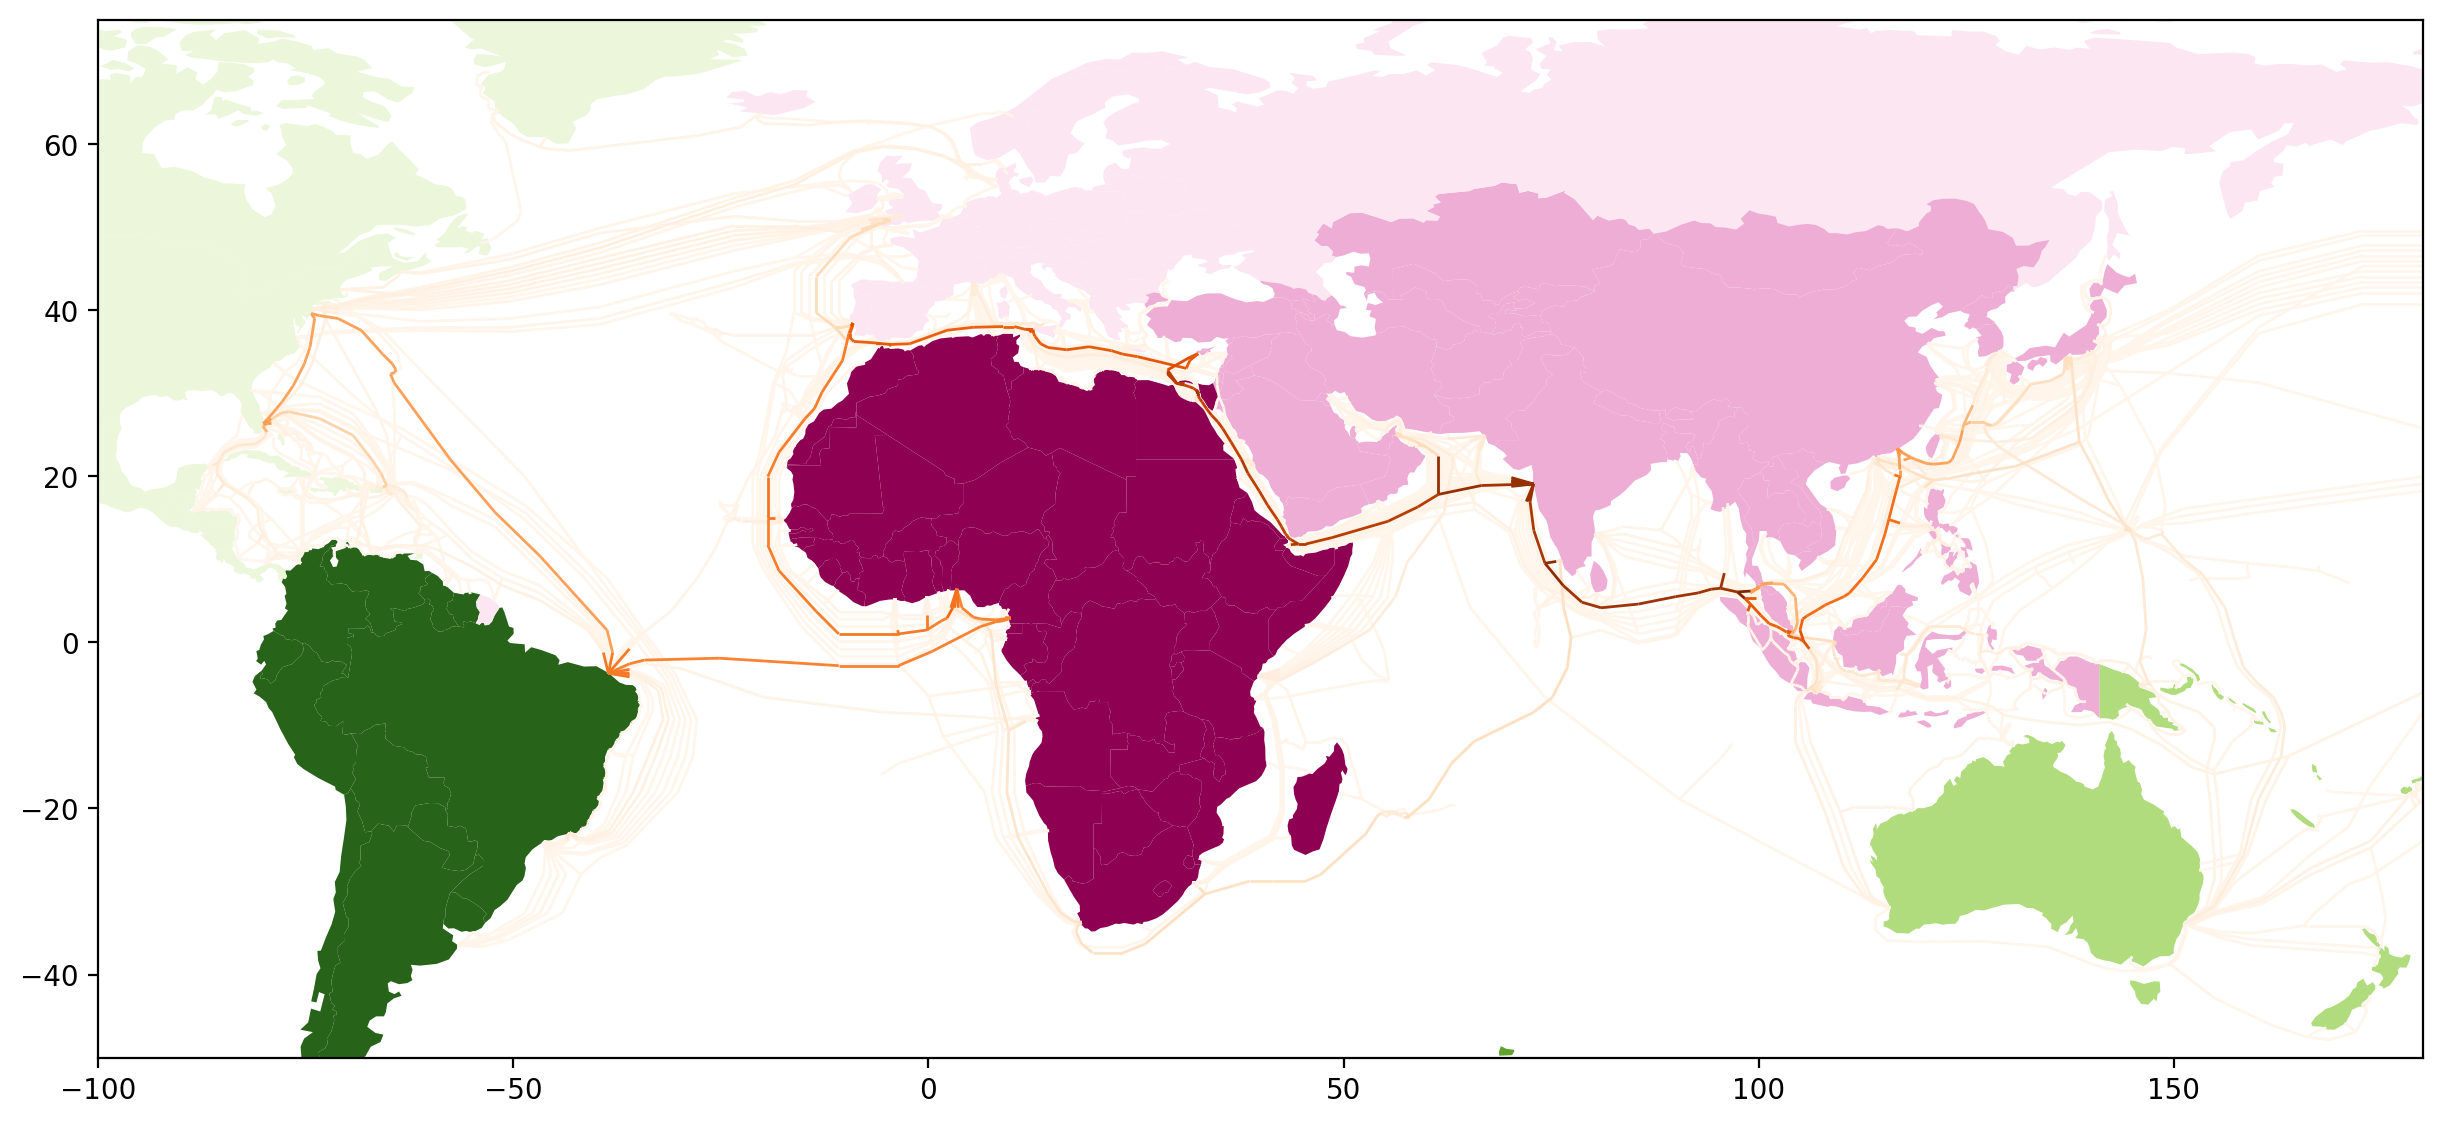

In [32]:
# df_betweennessCentrality_cost = df_betweennessCentrality_cost.sort_values(by=['betCentralityValue']).reset_index()
fig     = plt.figure(figsize=(15,10),dpi = 200)
ax      = plt.subplot(111)
worldMap.plot(column = 'continent', ax=ax, cmap = 'PiYG')
raw_centrality.merge(right=df_betweennessCentrality_capacity, how='inner',left_on='fr_id', right_on='betCentralityId').sort_values(by=['betCentralityValue']).plot(column = 'betCentralityValue',ax=ax,cmap='Oranges',linewidth=1)
plt.xlim([-100,180])
plt.ylim([-50,75])


In [33]:
# raw_centrality.
dict_betweennessCentrality_incerseCapacity = nx.algorithms.betweenness_centrality(G2,weight='inverse_capacity')
df_betweennessCentrality_incerseCapacity = pd.DataFrame({'betCentralityId': dict_betweennessCentrality_incerseCapacity.keys(), 'betCentralityValue': dict_betweennessCentrality_incerseCapacity.values()}).sort_values(by=['betCentralityValue'])


(-50.0, 75.0)

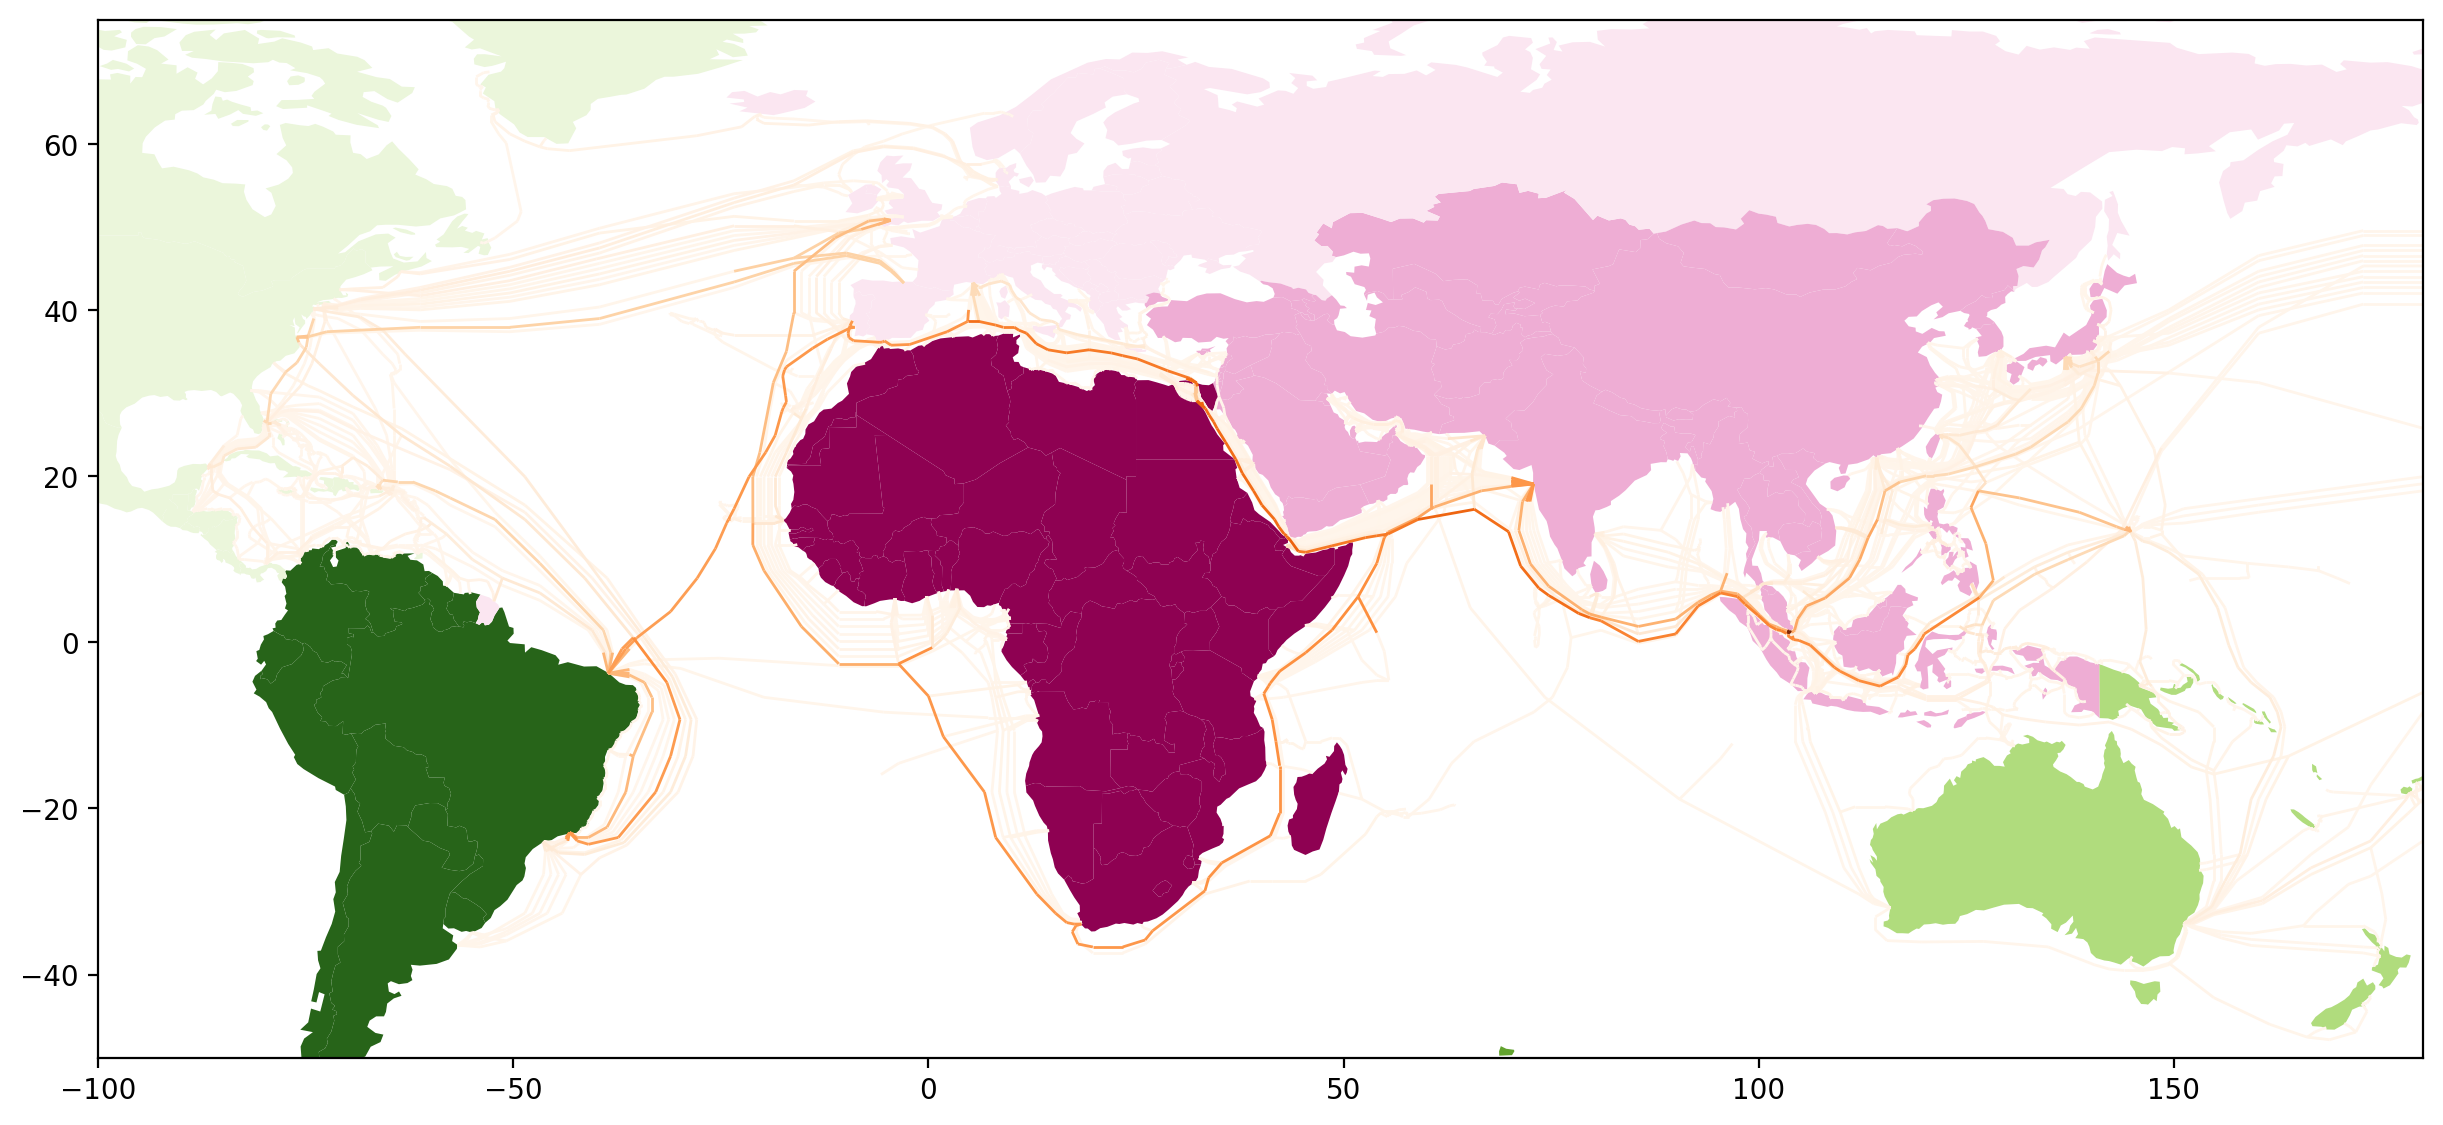

In [34]:
# df_betweennessCentrality_cost = df_betweennessCentrality_cost.sort_values(by=['betCentralityValue']).reset_index()
fig     = plt.figure(figsize=(15,10),dpi = 200)
ax      = plt.subplot(111)
worldMap.plot(column = 'continent', ax=ax, cmap = 'PiYG')
raw_centrality.merge(right=df_betweennessCentrality_incerseCapacity, how='inner',left_on='fr_id', right_on='betCentralityId').sort_values(by=['betCentralityValue']).plot(column = 'betCentralityValue',ax=ax,cmap='Oranges',linewidth=1)
plt.xlim([-100,180])
plt.ylim([-50,75])


In [35]:
with sqlite3.connect('../../Dataset/submarine_cable.sqlite') as con:
    c = con.cursor()
    pacific_landingPoint = pd.read_sql("select cable_id,cable_name,cable_length,landingPoint_id,landingPoint_name,landingPoint_country,landingPoint_longitude,landingPoint_latitude from landing_points where cable_id ='tui-samoa' or cable_id ='tonga-domestic-cable-extension-tdce' or cable_id ='tonga-cable' or cable_id ='samoa-american-samoa-sas' or landingPoint_id ='alofi-niue'",con=con)
pacific_landingPoint

,cable_id,cable_name,cable_length,landingPoint_id,landingPoint_name,landingPoint_country,landingPoint_longitude,landingPoint_latitude
0,samoa-american-samoa-sas,Samoa-American Samoa (SAS),250,pago-pago-american-samoa,"Pago Pago, American Samoa",American Samoa,-170.695713,-14.276549
1,samoa-american-samoa-sas,Samoa-American Samoa (SAS),250,apia-samoa,"Apia, Samoa",Samoa,-171.766679,-13.833403
2,tonga-domestic-cable-extension-tdce,Tonga Domestic Cable Extension (TDCE),410,neiafu-tonga,"Neiafu, Tonga",Tonga,-173.983685,-18.647685
3,tonga-domestic-cable-extension-tdce,Tonga Domestic Cable Extension (TDCE),410,nukualofa-tonga,"Nuku'alofa, Tonga",Tonga,-175.200032,-21.133286
4,tonga-domestic-cable-extension-tdce,Tonga Domestic Cable Extension (TDCE),410,pangai-tonga,"Pangai, Tonga",Tonga,-174.350261,-19.811428
5,tonga-cable,Tonga Cable,827,suva-fiji,"Suva, Fiji",Fiji,178.437448,-18.123638
6,tonga-cable,Tonga Cable,827,nukualofa-tonga,"Nuku'alofa, Tonga",Tonga,-175.200032,-21.133286
7,manatua,Manatua,3634,alofi-niue,"Alofi, Niue",Niue,-169.916704,-19.016701
8,tui-samoa,Tui-Samoa,1693,savusavu-fiji,"Savusavu, Fiji",Fiji,179.349753,-16.808014
9,tui-samoa,Tui-Samoa,1693,suva-fiji,"Suva, Fiji",Fiji,178.437448,-18.123638


(31, 18)


<AxesSubplot:>

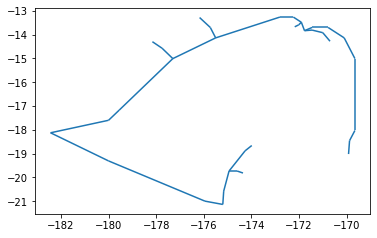

In [36]:
pacific_cable_gps = gdf[(gdf['cable_id'].isin(pacific_landingPoint['cable_id'])) & (gdf['lon1'] < -168)]
print(pacific_cable_gps.shape)
temp_gpf = gpd.GeoDataFrame([
[-182.43744782858172, -18.123638259082412, -179.999798,-19.305384,LineString([[-182.43744782858172, -18.123638259082412], [-179.999798,-19.305384]])],
[-182.43744782858172, -18.123638259082412, -179.999798,-17.597999,LineString([[-182.43744782858172, -18.123638259082412], [-179.999798,-17.597999]])]],columns=['lon1','lat1','lon2','lat2','geometry'],geometry='geometry')
temp_gpf['fr_id'] = round((round(temp_gpf['lon1'],5) + round(temp_gpf['lat1'],5))*100000,0)
temp_gpf['to_id'] = round((round(temp_gpf['lon2'],5) + round(temp_gpf['lat2'],5))*100000,0)
pacific_cable_gps = pacific_cable_gps.append(temp_gpf)
pacific_cable_gps.plot()

In [37]:
chinese_postman_lines = gpd.GeoDataFrame([
# [-175.20000165073517,-21.13346565929308,Point(-175.20000165073517,-21.13346565929308), -174.3521422513667,-19.81379624685283,Point(-174.3521422513667,-19.81379624685283)],
[-173.98368505307081,-18.65921570866675,Point(-173.98368505307081,-18.65921570866675), -170.6957048416213,-14.276544564158712,Point(-170.6957048416213,-14.276544564158712)],
[-169.91670539347172,-19.016714981418488,Point(-169.91670539347172,-19.016714981418488), -174.3521422513667,-19.81379624685283,Point(-174.3521422513667,-19.81379624685283)],
[-171.76669408292253,-13.833489255757883,Point(-171.76669408292253,-13.833489255757883), -172.17816102513325,-13.670594022635811,Point(-172.17816102513325,-13.670594022635811)],
[-178.1581082284118,-14.29683787673278,Point(-178.1581082284118,-14.29683787673278), -176.17500034981677,-13.28200057514735,Point(-176.17500034981677,-13.28200057514735)]],columns=['lon1','lat1','geometry_a', 'lon2','lat2','geometry_b'])
chinese_postman_lines['fr_id'] = round((round(chinese_postman_lines['lon1'],5) + round(chinese_postman_lines['lat1'],5))*100000,0)
chinese_postman_lines['to_id'] = round((round(chinese_postman_lines['lon2'],5) + round(chinese_postman_lines['lat2'],5))*100000,0)


<AxesSubplot:>

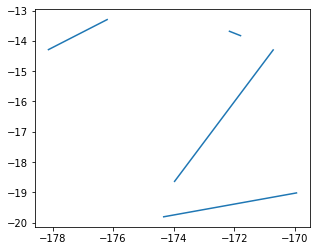

In [38]:
chinese_postman_lines['line'] = chinese_postman_lines.apply(lambda x: LineString([x['geometry_a'], x['geometry_b']]), axis=1)
target_gdf = gpd.GeoDataFrame(chinese_postman_lines, geometry=chinese_postman_lines['line'])
target_gdf['fr_point'] = gpd.points_from_xy(x=target_gdf['lon1'],y=target_gdf['lat1'])
target_gdf['to_point'] = gpd.points_from_xy(x=target_gdf['lon2'],y=target_gdf['lat2'])
target_gdf['distance_from_previous'] = target_gdf['fr_point'].distance(target_gdf['to_point'])
target_gdf['length_from_previous'] = target_gdf['distance_from_previous'] * 103.3934 + 51.6973
target_gdf.plot()

In [39]:
def chinese_postman():
    chinese_postman_lines['line'] = chinese_postman_lines.apply(lambda x: LineString([x['geometry_a'], x['geometry_b']]), axis=1)
    target_gdf = gpd.GeoDataFrame(chinese_postman_lines, geometry=chinese_postman_lines['line'])
    return target_gdf
chinese_postman_gdf = chinese_postman()

In [40]:
pacific_cable_gps.head(5)

,index,lon1,lat1,cable_id,cable_length,cable_capacity,cable_cost,lon2,lat2,fr_point,to_point,fr_id,to_id,distance_from_previous,total_distance,length_from_previous,line,geometry
630,703.0,-169.874805,-18.453814,manatua,3634.0,10.0,100.0,-169.649806,-18.026426,POINT (-169.87481 -18.45381),POINT (-169.64981 -18.02643),-18832862.0,-18767624.0,0.482996,32.680099,53.708730,LINESTRING (-169.87480542315404 -18.4538137757...,"LINESTRING (-169.87481 -18.45381, -169.64981 -..."
631,704.0,-169.916705,-19.016715,manatua,3634.0,10.0,100.0,-169.874805,-18.453814,POINT (-169.91671 -19.01671),POINT (-169.87481 -18.45381),-18893342.0,-18832862.0,0.564458,32.680099,62.767316,LINESTRING (-169.91670539347172 -19.0167149814...,"LINESTRING (-169.91671 -19.01671, -169.87481 -..."
632,706.0,-171.449804,-13.698987,manatua,3634.0,10.0,100.0,-171.766694,-13.833489,POINT (-171.44980 -13.69899),POINT (-171.76669 -13.83349),-18514879.0,-18560018.0,0.344253,32.680099,38.280614,LINESTRING (-171.44980430741003 -13.6989872696...,"LINESTRING (-171.44980 -13.69899, -171.76669 -..."
633,707.0,-170.774805,-13.698987,manatua,3634.0,10.0,100.0,-171.449804,-13.698987,POINT (-170.77480 -13.69899),POINT (-171.44980 -13.69899),-18447379.0,-18514879.0,0.675000,32.680099,75.059388,LINESTRING (-170.77480478558613 -13.6989872696...,"LINESTRING (-170.77480 -13.69899, -171.44980 -..."
634,708.0,-170.099805,-14.135775,manatua,3634.0,10.0,100.0,-170.774805,-13.698987,POINT (-170.09981 -14.13578),POINT (-170.77480 -13.69899),-18423559.0,-18447379.0,0.803995,32.680099,89.403596,LINESTRING (-170.0998052637621 -14.13577537506...,"LINESTRING (-170.09981 -14.13578, -170.77480 -..."


(-22.0, -12.0)

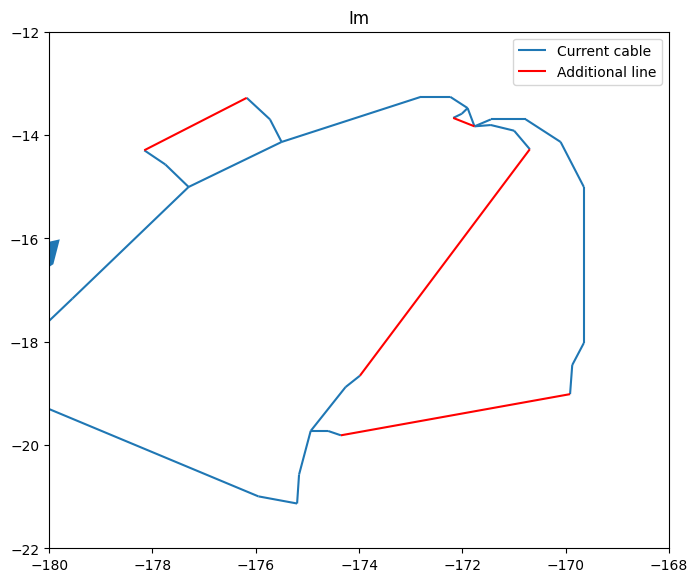

In [41]:
# world_basemap = gpd.read_file('/Users/dijiongyuequ/Downloads/GitHub/UCL_work/CW/Digital_Visualisation/CW2/dataset/World_Countries.geojson')
fig     = plt.figure(figsize=(8,8),dpi = 100)
ax      = plt.subplot(111)
worldMap.plot(ax=ax)
pacific_cable_gps.plot(ax=ax,label = 'Current cable')
chinese_postman_gdf.plot(ax=ax,color='r',label = 'Additional line')
plt.legend()
plt.title("Im")
plt.xlim([-180,-168])
plt.ylim([-22,-12])


In [42]:
G3 = nx.from_pandas_edgelist(pacific_cable_gps, 'fr_id', 'to_id', edge_attr=['index', 'length_from_previous','cable_capacity','cable_cost'], create_using=nx.Graph)

print(np.average(list(nx.algorithms.degree_centrality(G3).values())))

G4 = nx.from_pandas_edgelist(pacific_cable_gps.append(chinese_postman_gdf), 'fr_id', 'to_id', edge_attr=['index', 'length_from_previous','cable_capacity','cable_cost'], create_using=nx.Graph)
print(np.average(list(nx.algorithms.degree_centrality(G4).values())))

# chinese_postman_gdf.plot()
# pacific_cable_gps.plot()

0.058823529411764705
0.0659536541889483


In [43]:
temp = pacific_cable_gps

raw_centrality = temp[temp['fr_id'].isin(max(nx.connected_components(G3), key=len))]
raw_centrality['centrality'] = raw_centrality['fr_id'].map(nx.degree_centrality(G3))


world_map = folium.Map(location=[-17,-175], tiles="OpenStreetMap", zoom_start=6)

country_centrality=list(raw_centrality["centrality"]*100)
lon=list(raw_centrality["lon1"])
lat=list(raw_centrality["lat1"])
num=raw_centrality.shape[0]
for i in range(num):
    folium.CircleMarker(radius=float(country_centrality[i]),location=[lat[i],lon[i]],color="crimson",fill=True,fill_color="crimson",fill_opacity=0.7).add_to(world_map)
world_map

In [44]:
temp = pacific_cable_gps.append(chinese_postman_gdf)

raw_centrality = temp[temp['fr_id'].isin(max(nx.connected_components(G4), key=len))]
raw_centrality['centrality'] = raw_centrality['fr_id'].map(nx.degree_centrality(G4))


world_map = folium.Map(location=[-17,-175], tiles="OpenStreetMap", zoom_start=6)

country_centrality=list(raw_centrality["centrality"]*100)
lon=list(raw_centrality["lon1"])
lat=list(raw_centrality["lat1"])
num=raw_centrality.shape[0]
for i in range(num):
    folium.CircleMarker(radius=float(country_centrality[i]),location=[lat[i],lon[i]],color="crimson",fill=True,fill_color="crimson",fill_opacity=0.7).add_to(world_map)
world_map

In [45]:
# world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# world



In [46]:

{k:v for k, v in nx.algorithms.bipartite.node_redundancy(G4).items() if v>0}
# nx.draw_networkx_edges(G4, pos=nx.circular_layout(G4))

# for x in (nx.connected_components(G4)):
#     print(len(x))


# max(nx.connected_components(G4), key=len)

{-18560018.0: 0.16666666666666666,
 -18538009.0: 0.3333333333333333,
 -18560196.0: 1.0,
 -18584875.0: 1.0}

<AxesSubplot:>

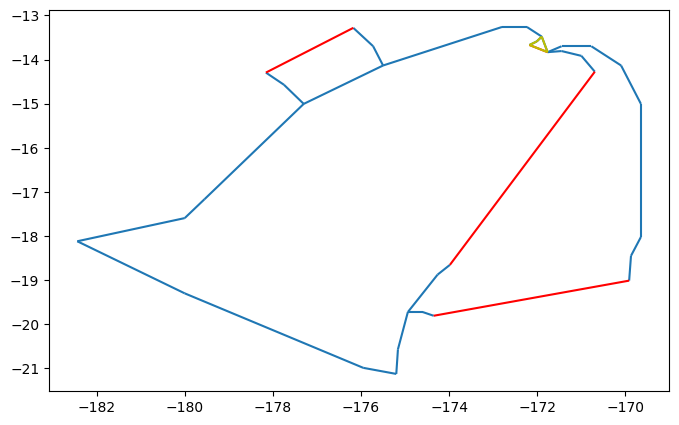

In [47]:
temp = pacific_cable_gps.append(chinese_postman_gdf)


fig     = plt.figure(figsize=(8,8),dpi = 100)
ax      = plt.subplot(111)
pacific_cable_gps.plot(ax=ax,label = 'Current cable')
chinese_postman_gdf.plot(ax=ax,color='r',label = 'Additional line')
temp[temp['fr_id'].isin({k:v for k, v in nx.algorithms.bipartite.node_redundancy(G4).items() if v>0}.keys())].plot(ax=ax,label = 'Redundance', color='y')
